In [1]:
import holidays
import os
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy.signal import find_peaks
from skimage.restoration import (denoise_wavelet, estimate_sigma)
import matplotlib.pyplot as plt
import sys
sys.path.append('../lib/')
from utils import *
from preprocessing_analysis import * 

# Data preprocessing

In [2]:
filepath_data = '../Data/'
filename = 'daneOkresoweKSE.csv'


data = pd.read_csv(filepath_data + filename, sep=';', 
                   skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])

data['Date'] = pd.to_datetime(data.Date)
data.loc[data.Hour == 24, 
             'Date'] = data.loc[data.Hour == 24, 'Date'] + timedelta(days=1)
data.loc[data.Hour == 24, 'Hour'] = 0
data.Date = pd.to_datetime(data.Date.astype(str) + ' ' + 
                               data['Hour'].astype(str) + ':' + 
                               data.Minute.astype(str) + ':00')

data = data[['Date', 'Load']]
data['Minutes'] = data['Date'].dt.minute
data['Hour'] = data['Date'].dt.hour

data

,Date,Load,Minutes,Hour
0,2008-01-01 00:15:00,15938.8,15,0
1,2008-01-01 00:30:00,15770.4,30,0
2,2008-01-01 00:45:00,15766.3,45,0
3,2008-01-01 01:00:00,15415.2,0,1
4,2008-01-01 01:15:00,15351.8,15,1
...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23
315644,2016-12-31 23:15:00,15865.3,15,23
315645,2016-12-31 23:30:00,15693.5,30,23
315646,2016-12-31 23:45:00,15508.3,45,23


# Data visualization

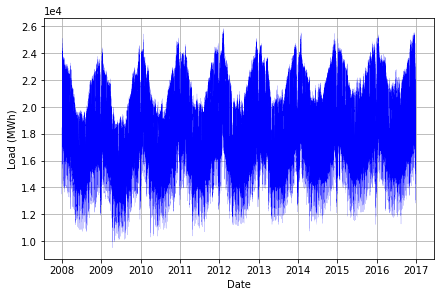

In [3]:
plot_data(
    df=data,
    file='Poland_Load',
    lw=0.1
)

# Wavelet denoising: 
### BayesShrink method for universal threshold for wavelet denoising

In [4]:
# Estimate the average noise standard deviation
sigma_est = estimate_sigma(data.Load.to_numpy())

wavelet_name = 'sym4'
bayes = denoise_wavelet(data.Load.to_numpy(), method='BayesShrink', mode='soft',
                        wavelet=wavelet_name, rescale_sigma=True)

data['Load_denoised'] = bayes

data

,Date,Load,Minutes,Hour,Load_denoised
0,2008-01-01 00:15:00,15938.8,15,0,15874.399259
1,2008-01-01 00:30:00,15770.4,30,0,15798.092164
2,2008-01-01 00:45:00,15766.3,45,0,15674.312237
3,2008-01-01 01:00:00,15415.2,0,1,15516.701660
4,2008-01-01 01:15:00,15351.8,15,1,15333.232841
...,...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23,15998.020995
315644,2016-12-31 23:15:00,15865.3,15,23,15843.774983
315645,2016-12-31 23:30:00,15693.5,30,23,15640.409344
315646,2016-12-31 23:45:00,15508.3,45,23,15455.279247


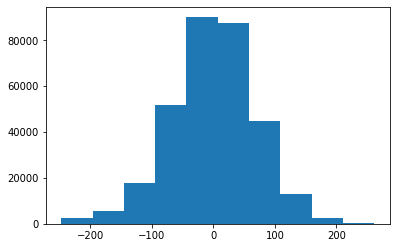

In [5]:
ax = latex_settings()
ax.hist(data.Load.to_numpy() - bayes);

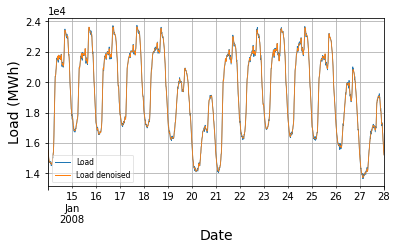

In [6]:
ax = latex_settings()

start = 96*7*2-96     # dataset's second week
stop = 96*7*4-96      # dataset's fourth week 

data.loc[start:stop, ['Date', 'Load', 'Load_denoised']].set_index('Date').plot(ax=ax, lw=0.8)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.set_xlabel('Date')
ax.set_ylabel('Load (MWh)')
ax.grid(which='both')
leg = ax.legend(labels=['Load', 'Load denoised'], fancybox=True, framealpha=0.5,
          fontsize=7.5)
for lh in leg.legendHandles: 
    lh.set_linewidth(1)

filepath = '../Images/'
file = f'Poland_Load_denoised_bayes_{wavelet_name}'
if os.path.isfile(filepath + file):
    pass
else:    
    plt.savefig(f'{filepath}{file}.png', dpi=800, transparent=True)

plt.show()

# Seasonal and trend component

In [7]:
feature = 'Load_denoised'
x = data[feature].to_numpy()

n = x.size  
t = np.arange(0, n)
p = np.polyfit(t, x, 1)

print(p)

seasonal_comp = fourierExtrapolation(
    data[feature].to_numpy(),
    n_harm=10)

Load_lin = linear_fit(x=data.index, y=data[feature])
data['Load_lin_seasonal'] = Load_lin + seasonal_comp
data['Load_real_comp'] = data[feature] - data['Load_lin_seasonal']


filename = f'Poland_Load_preprocessed_denoised_{wavelet_name}.csv'
if os.path.isfile(filepath_data + filename):
    pass
else:  
    data.to_csv(filepath_data + filename, index=False)

data

[4.95513840e-03 1.71953124e+04]


,Date,Load,Minutes,Hour,Load_denoised,Load_lin_seasonal,Load_real_comp
0,2008-01-01 00:15:00,15938.8,15,0,15874.399259,19057.878671,-3183.479412
1,2008-01-01 00:30:00,15770.4,30,0,15798.092164,19057.903960,-3259.811796
2,2008-01-01 00:45:00,15766.3,45,0,15674.312237,19057.929200,-3383.616963
3,2008-01-01 01:00:00,15415.2,0,1,15516.701660,19057.954393,-3541.252734
4,2008-01-01 01:15:00,15351.8,15,1,15333.232841,19057.979539,-3724.746698
...,...,...,...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23,15998.020995,20621.831045,-4623.810050
315644,2016-12-31 23:15:00,15865.3,15,23,15843.774983,20621.856571,-4778.081587
315645,2016-12-31 23:30:00,15693.5,30,23,15640.409344,20621.882049,-4981.472705
315646,2016-12-31 23:45:00,15508.3,45,23,15455.279247,20621.907479,-5166.628232


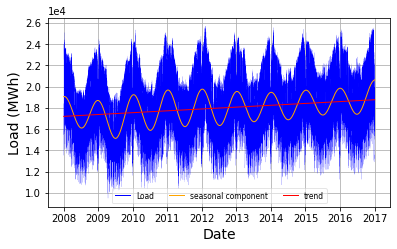

In [8]:
ax = latex_settings()

ax.plot(data['Date'], data['Load_denoised'], 'b', lw=0.1, label='Load')
ax.plot(data['Date'], seasonal_comp + Load_lin, 'orange', lw=1, label='seasonal component')
ax.plot(data['Date'], Load_lin, 'r', lw=1, label='trend')
ax.grid()
#plt.xticks(rotation=45)
ax.set_xlabel('Date')
ax.set_ylabel('Load (MWh)')
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
leg = ax.legend(loc="lower center", ncol=3, fancybox=True, framealpha=0.5,
                    fontsize=7.5)
fancy_legend(leg)
plt.savefig('../Images/Poland_Load_components.png', dpi=800, transparent=True)

# Resampling data hourly

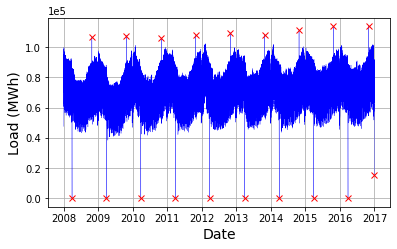

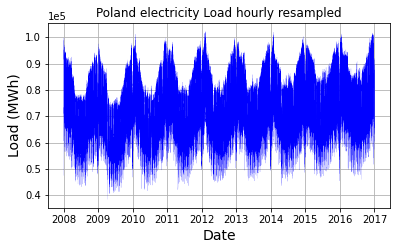

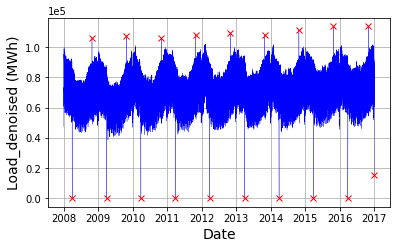

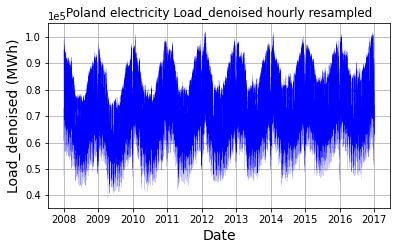

,Date,Hour,Minutes,Load,Load_denoised,Day,Holiday,Day id,Load_detrend,Load_lin_seasonal,Load_real_comp
0,2008-01-01 00:00:00,0.0,30.0,47475.5,47346.803660,1,True,1,-21433.170550,76229.951636,-28883.147976
1,2008-01-01 01:00:00,1.0,22.5,60819.9,60916.440498,1,True,1,-7863.613023,76230.351592,-15313.911094
2,2008-01-01 02:00:00,2.0,22.5,57869.8,57844.668724,1,True,1,-10935.464108,76230.748508,-18386.079784
3,2008-01-01 03:00:00,3.0,22.5,55672.8,55751.026446,1,True,1,-13029.185696,76231.142384,-20480.115938
4,2008-01-01 04:00:00,4.0,22.5,55331.7,55269.909471,1,True,1,-13510.381982,76231.533220,-20961.623749
...,...,...,...,...,...,...,...,...,...,...,...
78907,2016-12-31 19:00:00,19.0,22.5,74952.5,74961.384819,5,False,366,-76.752067,82486.465497,-7525.080678
78908,2016-12-31 20:00:00,20.0,22.5,70390.3,70477.880585,5,False,366,-4560.335612,82486.880648,-12009.000063
78909,2016-12-31 21:00:00,21.0,22.5,66925.1,66827.278809,5,False,366,-8211.016698,82487.292761,-15660.013952
78910,2016-12-31 22:00:00,22.0,22.5,64900.1,64921.358977,5,False,366,-10117.015841,82487.701835,-17566.342858


In [9]:
filename = 'Poland_Load_H_resampled'
features = ['Load', 'Load_denoised']
df = resampling_data(df=data, features=features, resample_cost='h')

df.reset_index(drop=False, inplace=True)
df['Day'] = df.Date.dt.day_of_week
poland_holidays = holidays.CountryHoliday('Poland')
df['Holiday'] = df.Date.apply(lambda x: x in poland_holidays)
df['Day id'] = df.Date.dt.day_of_year

for feature in features:
    peaks_up, _  = find_peaks(df[feature], distance=5000)
    peaks_down, _  = find_peaks(-df[feature], distance=5000)
    # add and remove peaks that are not detected
    peaks = np.concatenate((peaks_down[:-1], peaks_up[1:], [len(df)-1]))

    plot_data(
        df=df,
        file=filename + f'_{feature}_peaks',
        peaks=peaks,
        lw=0.3,
        feature=feature
        )

    peaks = peaks[:-1]
    df.loc[peaks, feature] = np.nan
    df[feature].interpolate(inplace=True)
    df = df[~df[feature].isna()].reset_index(drop=True)

    plot_data(
        df=df.iloc[:-1],
        title=f'Poland electricity {feature} hourly resampled',
        file=filename + f'_{feature}',
        lw=0.1,
        feature=feature
    )

feature = 'Load_denoised'
# remove the last row
df = df.iloc[:-1]

# remove the trend and seasonal components from the data
seasonal_comp = fourierExtrapolation(
    df[feature].to_numpy(),
    n_harm=10)

Load_lin = linear_fit(x=df.index, y=df[feature])
df['Load_detrend'] = df[feature] - Load_lin
df['Load_lin_seasonal'] = Load_lin + seasonal_comp
df['Load_real_comp'] = df[feature] - df['Load_lin_seasonal']

filepath = '../Data/'
file = filename + '.csv'
if os.path.isfile(filepath + file):
    pass
else:
    df.to_csv(filepath + file, index=False)

df

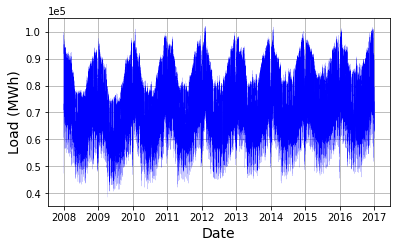

In [12]:
lw = 0.1
feature = 'Load_denoised'
title = None
file = f'Poland_{feature}_H_resampled'

ax = latex_settings()
ax.plot(df['Date'], df[feature], 'b', lw=lw)

ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel(f'Load (MWh)')
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(title)

filepath = '../Images/'
#if os.path.isfile(filepath + file):
    #pass
#else:    
    #plt.savefig(f'{filepath}{file}.png', dpi=800, transparent=True)

plt.show()

# Resampling data dayly

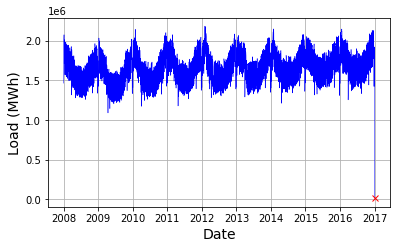

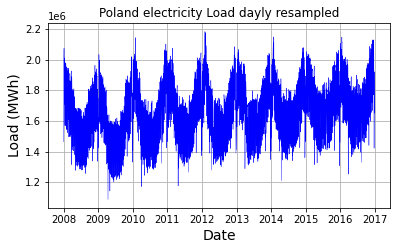

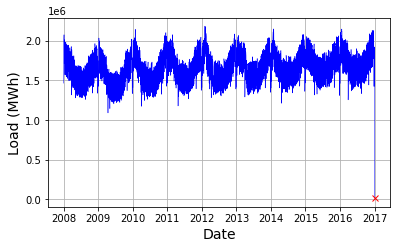

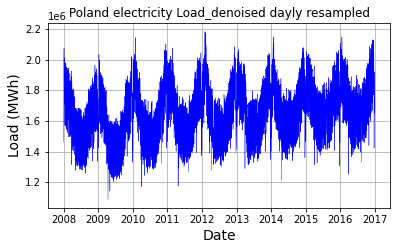

,Date,Hour,Minutes,Load,Load_denoised,Load_lin,Load_detrend
0,2008-01-01,11.621053,22.736842,1464842.5,1.464816e+06,1.650746e+06,-185903.375157
1,2008-01-02,11.500000,22.500000,1900414.4,1.900407e+06,1.650792e+06,249622.844845
2,2008-01-03,11.500000,22.500000,2023765.7,2.023846e+06,1.650837e+06,372928.464848
3,2008-01-04,11.500000,22.500000,2074081.7,2.074155e+06,1.650883e+06,423198.784850
4,2008-01-05,11.500000,22.500000,1910250.4,1.910096e+06,1.650929e+06,259321.804852
...,...,...,...,...,...,...,...
3283,2016-12-27,11.500000,22.500000,1788972.9,1.789020e+06,1.800713e+06,-11740.407468
3284,2016-12-28,11.500000,22.500000,1920741.9,1.920609e+06,1.800759e+06,119982.912534
3285,2016-12-29,11.500000,22.500000,1908350.9,1.908360e+06,1.800805e+06,107546.232537
3286,2016-12-30,11.500000,22.500000,1875408.2,1.875350e+06,1.800850e+06,74557.852539


In [13]:
filename = 'Poland_Load_D_resampled'
features = ['Load', 'Load_denoised']

df = resampling_data(data, features=features, resample_cost='d')
df.reset_index(drop=False, inplace=True)
peaks = np.array([len(df)-1])

for feature in features:
    plot_data(
        df=df,
        file=filename + f'_{feature}_peaks',
        peaks=peaks,
        lw=0.5
        )

    plot_data(
        df=df.iloc[:-1],
        title=f'Poland electricity {feature} dayly resampled',
        file=filename + f'_{feature}',
        lw=0.4
    )

feature = 'Load'
# remove last row
df = df.iloc[:-1]

# remove the trend component from the data
df['Load_lin'] = linear_fit(x=df.index, y=df[feature])
df['Load_detrend'] = df[feature] - df['Load_lin']


filepath = '../Data/'
file = filename + '.csv'
if os.path.isfile(filepath + file):
    pass
else:  
    df.to_csv(filepath + file, index=False)

df

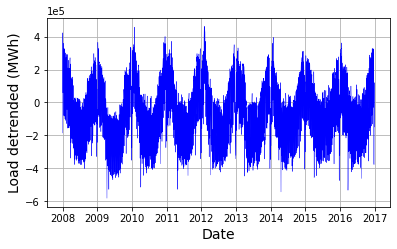

In [15]:
lw = 0.4
feature = 'Load_detrend'
title = None
file = f'Poland_{feature}_denoised_D_resampled'

ax = latex_settings()
ax.plot(df['Date'], df[feature], 'b', lw=lw)

ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel(f'Load detrended (MWh)')
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(title)

filepath = '../Images/'
if os.path.isfile(filepath + file):
    pass
else:    
    plt.savefig(f'{filepath}{file}.png', dpi=800, transparent=True)

plt.show()

# Resampling data weekly

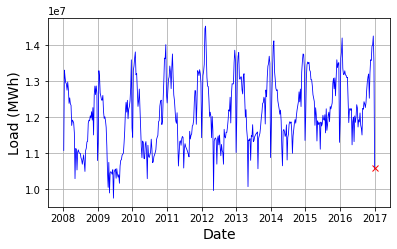

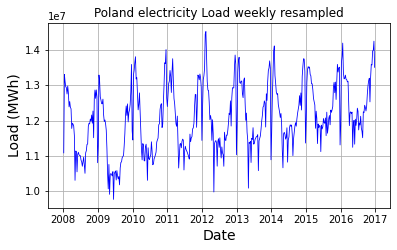

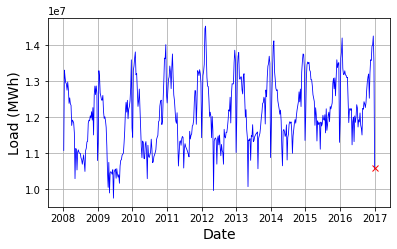

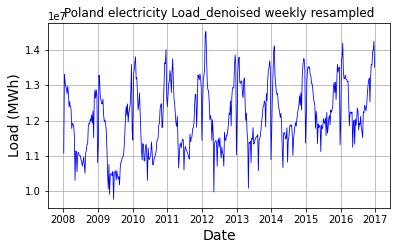

,Date,Hour,Minutes,Load,Load_lin,Load_detrend
0,2008-01-06,11.52,22.53913,11081984.7,1.153853e+07,-4.565480e+05
1,2008-01-13,11.50,22.50000,13312844.7,1.154083e+07,1.772013e+06
2,2008-01-20,11.50,22.50000,13109142.4,1.154313e+07,1.566011e+06
3,2008-01-27,11.50,22.50000,12963823.6,1.154543e+07,1.418392e+06
4,2008-02-03,11.50,22.50000,12932126.7,1.154773e+07,1.384396e+06
...,...,...,...,...,...,...
464,2016-11-27,11.50,22.50000,13581364.1,1.260550e+07,9.758681e+05
465,2016-12-04,11.50,22.50000,13978036.2,1.260780e+07,1.370241e+06
466,2016-12-11,11.50,22.50000,14004313.2,1.261009e+07,1.394218e+06
467,2016-12-18,11.50,22.50000,14259329.9,1.261239e+07,1.646935e+06


In [16]:
filename = 'Poland_Load_W_resampled'
features = ['Load', 'Load_denoised']

df = resampling_data(data, resample_cost='W')
df.reset_index(drop=False, inplace=True)

# removed last data because it the start of the week and cannot be summed
peaks = np.array([len(df)-1])

for feature in features:
    plot_data(
        df=df,
        file=filename + f'_{feature}_peaks',
        peaks=peaks,
        lw=0.8
        )

    plot_data(
        df=df.iloc[:-1],
        title=f'Poland electricity {feature} weekly resampled',
        file=filename + f'_{feature}',
        lw=0.8
    )

feature = 'Load'
# remove last row
df = df.iloc[:-1]

# remove the trend component from the data
df['Load_lin'] = linear_fit(x=df.index, y=df[feature])
df['Load_detrend'] = df[feature] - df['Load_lin']

file = filename + '.csv'
if os.path.isfile(filepath + file):
    pass
else:  
    df.to_csv(filepath + file, index=False)

df

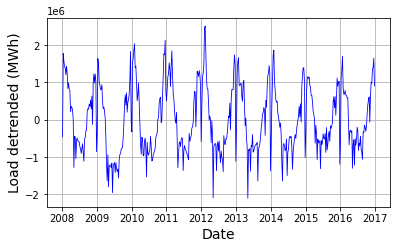

In [17]:
lw = 0.8
feature = 'Load_detrend'
title = None
file = f'Poland_{feature}_denoised_W_resampled'

ax = latex_settings()
ax.plot(df['Date'], df[feature], 'b', lw=lw)

ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel(f'Load detrended (MWh)')
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(title)

filepath = '../Images/'
if os.path.isfile(filepath + file):
    pass
else:    
    plt.savefig(f'{filepath}{file}.png', dpi=800, transparent=True)

plt.show()